In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib.animation import FuncAnimation


In [ ]:
class Sin(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

class FCN(nn.Module):
    """Fully Connected Network."""
    def __init__(self, n_in, n_out, n_units, n_layers):
        super().__init__()
        # activation = nn.Tanh
        activation = Sin

        self.fcs = nn.Sequential(*[
                        nn.Linear(n_in, n_units),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                        nn.Linear(n_units, n_units),
                        activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_units, n_out)
    def forward(self, r):
        r = self.fcs(r)
        r = self.fch(r)
        r = self.fce(r)
        return r

In [3]:
# Define parameters
c = 343.0
f = 1000.0
k = 2 * np.pi * f / c
L = 1.0
T = 1e-3

r = np.linspace(0.1, L, 50)
t = np.linspace(0, T, 50)
r_grid, t_grid = np.meshgrid(r, t)
rt = np.array([r_grid.flatten(), t_grid.flatten()]).T

p_ref = np.exp(1j * (2 * np.pi * f * rt[:, 1] - k * rt[:, 0])) / (4 * np.pi * rt[:, 0])
p_ref = p_ref.real.reshape(r_grid.shape)

In [4]:
p_obs = p_ref[:, 0:50:5].copy()
p_obs += 0.1 * np.random.randn(p_obs.shape[0],p_obs.shape[1]) * np.sqrt(np.mean(np.abs(p_obs)**2))
r_obs = r[0:50:5]
rt_obs = np.array([r_grid[:, 0:50:5].flatten(), t_grid[:, 0:50:5].flatten()]).T

# fig = plt.figure(figsize=(6, 4))
# line, = plt.plot(r, p_ref[0, :])
# plt.ylim(-1, 1)
# plt.xlabel('r (m)')
# plt.ylabel('Pressure')

# def update(frame):
#     line.set_ydata(p_ref[frame, :])
#     for coll in plt.gca().collections:
#         coll.remove()
#     plt.scatter(r_obs, p_obs[frame, :], color='red', label='Observations')
#     plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
#     return line,

# ani = FuncAnimation(fig, update, frames=p_ref.shape[0], interval=100, blit=True)
# ani.save('wave_animation.gif', writer='pillow', fps=10)

In [5]:
n_in = 2
n_out = 1
n_hidden = 32
n_layers = 3
n_epochs = int(2e1)

rt_obs = torch.tensor(rt_obs, dtype=torch.float32).requires_grad_(True)
p_obs = torch.tensor(p_obs.reshape(-1,1), dtype=torch.float32).requires_grad_(True)
rt = torch.tensor(rt, dtype=torch.float32).requires_grad_(True)

model = FCN(n_in, n_out, n_hidden, n_layers)

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    p = model(rt_obs)
    loss = mse_loss(p, p_obs)

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
    loss_history.append(loss.item())


100%|██████████| 20/20 [00:00<00:00, 46.94it/s]


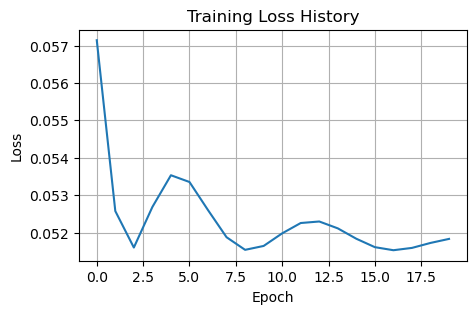

In [6]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

In [7]:
p_rec = model(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

# fig = plt.figure(figsize=(6, 4))
# line, = plt.plot(r, p_rec[0, :])
# plt.ylim(-1, 1)
# plt.xlabel('r (m)')
# plt.ylabel('Pressure')

# def update(frame):
#     line.set_ydata(p_rec[frame, :])
#     plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
#     return line,

# ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
# ani.save('wave_animation_model.gif', writer='pillow', fps=10)

In [23]:
def pde_residual(p, rt, c):
    p_rt = torch.autograd.grad(p, rt, torch.ones_like(p), create_graph=True)[0]
    p_rr = torch.autograd.grad(p_rt[:,0], rt, torch.ones_like(p_rt[:,0]), create_graph=True)[0][:,0:1]
    p_tt = torch.autograd.grad(p_rt[:,1], rt, torch.ones_like(p_rt[:,1]), create_graph=True)[0][:,1:2]
    pde_res = p_rr - p_tt / c**2
    return pde_res

def loss_grad_norm(loss, model):
    loss_grad_norm = 0
    loss_clone = loss.clone()
    for params in model.parameters():
        loss_grad = torch.autograd.grad(loss_clone, params, retain_graph=True, allow_unused=True, materialize_grads=True)[0]
        loss_grad_norm += torch.sum(loss_grad**2)
    loss_grad_norm = loss_grad_norm**0.5
    loss_grad_norm = loss_grad_norm.detach()
    return loss_grad_norm

def update_lambda(model, loss_lst, lamb_lst, alpha):
    grad = []
    for loss in loss_lst:
        grad.append(loss_grad_norm(loss, model))
    grad_sum = sum(grad)
    lamb = []
    for i in range(len(grad)):
        lamb_hat = grad_sum / grad[i]
        if torch.isnan(lamb_hat) or torch.isinf(lamb_hat):
            lamb_hat = torch.ones_like(lamb_hat)
        lamb_new = alpha*lamb_lst[i] + (1-alpha)*lamb_hat
        lamb.append(lamb_new)
    return lamb

# alpha = 1
alphas = [1, 1]
model_pinn = FCN(n_in, n_out, n_hidden, n_layers)
# model_pinn = model
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)

n_epochs = int(1e4)


In [24]:

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    
    p = model_pinn(rt_obs)
    loss_obs = mse_loss(p, p_obs)

    # r_collocation = torch.randn_like(rt_obs, dtype=torch.float32, requires_grad=True) * torch.tensor([L, T])
    # p = model(r_collocation)
    # loss_pde = torch.mean(torch.abs(pde_residual(p, r_collocation, c)**2))
    p = model_pinn(rt)
    # loss_pde = torch.mean(torch.abs(pde_residual(p, rt, c)**2))
    loss_pde = mse_loss(pde_residual(p, rt, c), torch.zeros_like(p))

    if i % 10 == 0:
        alphas = update_lambda(model_pinn, [loss_obs, loss_pde], alphas, 0.9)

    loss = alphas[0]*loss_obs + alphas[1]*loss_pde

    # backpropagate
    loss.backward()
    optimizer.step()
    # if i == 0:
    #     loss_history = []
    #     loss_obs_history = []
    #     loss_pde_history = []
    loss_history.append(loss.item())
    loss_obs_history.append(loss_obs.item())
    loss_pde_history.append(loss_pde.item())

    # if rem(i,1000) == 0:
        # print(loss)


 38%|███▊      | 3750/10000 [08:43<14:31,  7.17it/s]  


KeyboardInterrupt: 

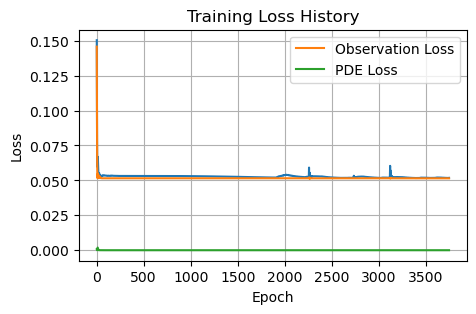

In [25]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.plot(np.array(loss_obs_history), label='Observation Loss')
plt.plot(np.array(loss_pde_history), label='PDE Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

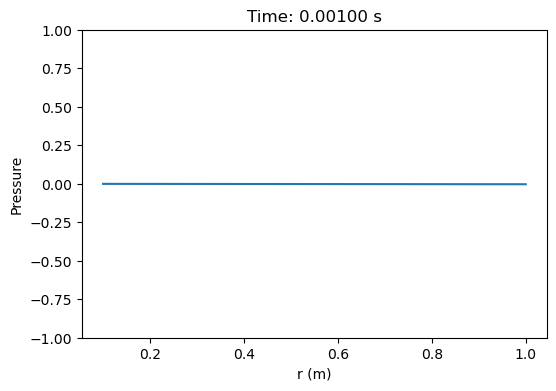

In [26]:
p_rec = model_pinn(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line,

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
ani.save('wave_animation_pinn.gif', writer='pillow', fps=10)

Estimate the speed of sound